# Plot some graphs for trade predictions

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os 
import sys

In [7]:
sys.path.append('../')

In [8]:
import pandas as pd
import json
from sklearn.metrics import accuracy_score
import plotly.express as px
import plotly.graph_objects as go


In [18]:
path = '../reports/trade_forecast/'
ticker = 'BTC-USD'
n = 10

In [19]:
def open_json(path):
    with open(path) as file:
        res = json.loads(file.read())
    return res

def get_result_df(res, n):
    models = list(res.keys())
    res_df = pd.DataFrame()
    res_df['date'] = [i['date'] for i in res[models[0]]]
    res_df['target'] = [i['target'][0] for i in res[models[0]]]
    res_df.set_index('date', inplace=True)
    for model in models:
        res_df[model] = [accuracy_score(i['pred'][:n], i['test'][:n]) for i in res[model]]
    res_df = res_df.sort_index()[:'2021-01-01']
    res_df['random_prediction'] = 1 / 3
    return res_df

In [22]:
def plot_result_df(res_df):
    fig = go.Figure()
    df = res_df.drop('target', axis=1)
    for model in df.columns:
        fig.add_trace(go.Scatter(x=df.index, y=df[model], name=model))
    fig.update_layout(title='Compare accuracy to random prediction',
                       xaxis_title='Date',
                       yaxis_title='Accuracy')
    fig.write_image('image.png')
    fig.show()

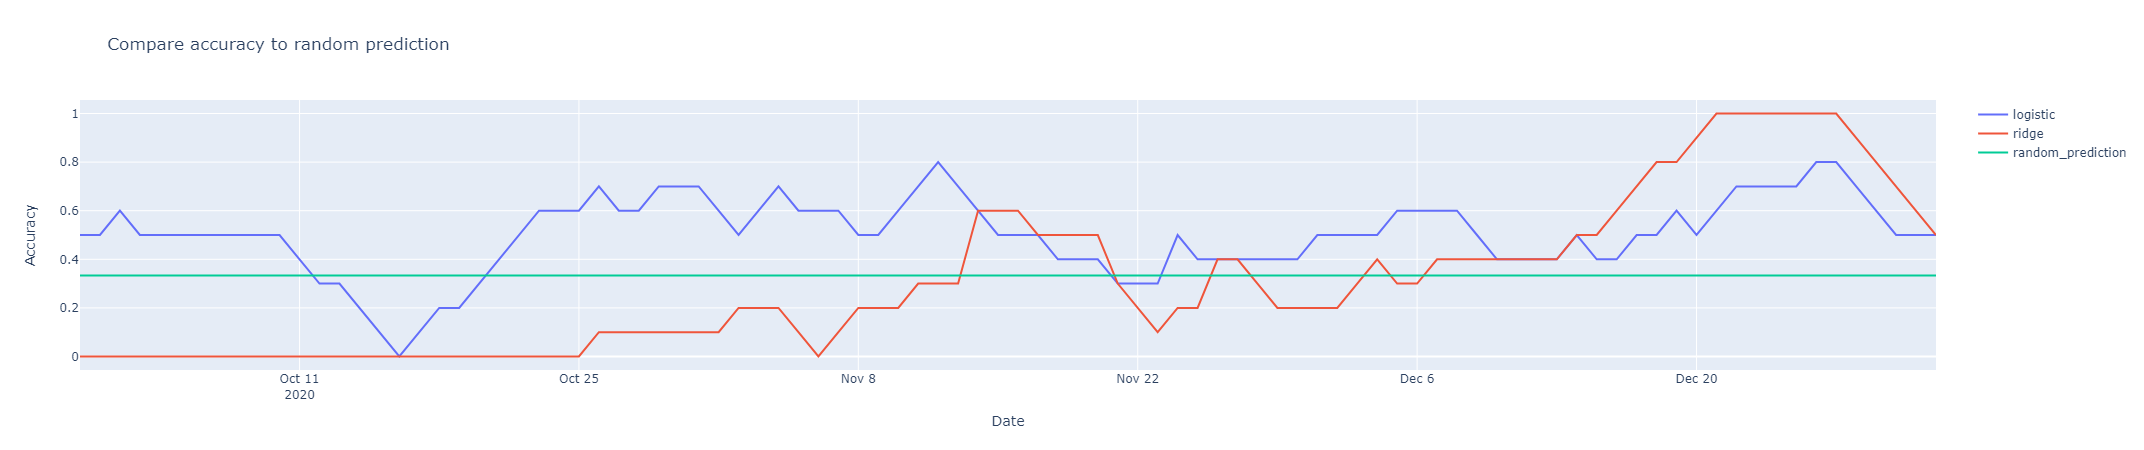

In [23]:
res = open_json(path + ticker + '.json')
res_df = get_result_df(res, n)
plot_result_df(res_df)
# res_df

## Play simulation

In [24]:
from src.trade import Simulation
import numpy as np

In [25]:
def map_int_to_str(x):
    if x == 0:
        return 'hold'
    if x == 1:
        return 'sell'
    if x == 2:
        return 'buy'
    raise ValueError(f'Bad value: {x}, must be 0, 1 or 2')

In [26]:
def get_simulation_df(res):
    models = list(res.keys())
    res_df = pd.DataFrame()
    res_df['date'] = [i['date'] for i in res[models[0]]]
    res_df['target'] = [i['target'][0] for i in res[models[0]]]
    res_df['actual_labels'] = [i['test'][0] for i in res[models[0]]]
    res_df.set_index('date', inplace=True)

    for model in models:
        res_df[model] = [i['pred'][0] for i in res[model]]
    
    res_df = res_df.sort_index()[:'2021-01-01']
    res_df['random_labels'] = np.random.randint(0, 3, (len(res_df),)).tolist()
    res_df['random_labels'] = res_df['random_labels'].apply(map_int_to_str)
    return res_df

In [27]:
res = open_json(path + ticker + '.json')
simulation_df = get_simulation_df(res)
simulation_df.head()

,target,actual_labels,logistic,ridge,random_labels
date,,,,,
2020-09-30,10623.330078,hold,sell,sell,hold
2020-10-01,10585.164062,buy,sell,sell,hold
2020-10-02,10565.493164,hold,hold,sell,sell
2020-10-03,10684.428711,hold,hold,sell,hold
2020-10-04,10804.000977,hold,hold,sell,sell


In [28]:
def play(simulation_df, model, cap=15000):
    cap, log = Simulation(15000).play_simulation(simulation_df, model)
    return cap, log

In [29]:
models = simulation_df.drop('target', axis=1)

In [37]:
caps = {}
logs = {}
for model in models:
    caps[model], logs[model] = play(simulation_df, model, cap=15000)
    logs[model].index.name = caps[model]
caps

{'actual_labels': 38603.375,
 'logistic': 35478.7421875,
 'ridge': 14965.6474609375,
 'random_labels': 19492.849609375}

In [35]:
logs['actual_labels'].index.name = ''

In [38]:
logs['actual_labels']

,type,price,vol,cap,cur_vol
38603.375,,,,,
0,buy,10585.164062,1,4414.835938,1
1,sell,16276.343750,1,20691.179688,0
2,buy,16317.808594,1,4373.371094,1
3,sell,18364.121094,1,22737.492188,0
4,buy,17150.623047,1,5586.869141,1
5,sell,19154.230469,1,24741.099609,0
6,buy,18264.992188,1,6476.107422,1
7,sell,32127.267578,1,38603.375000,0


In [221]:
logs['ridge']

,type,price,vol,cap,cur_vol
0,buy,12965.891602,1,2034.108398,1
1,sell,12931.539062,1,14965.647461,0


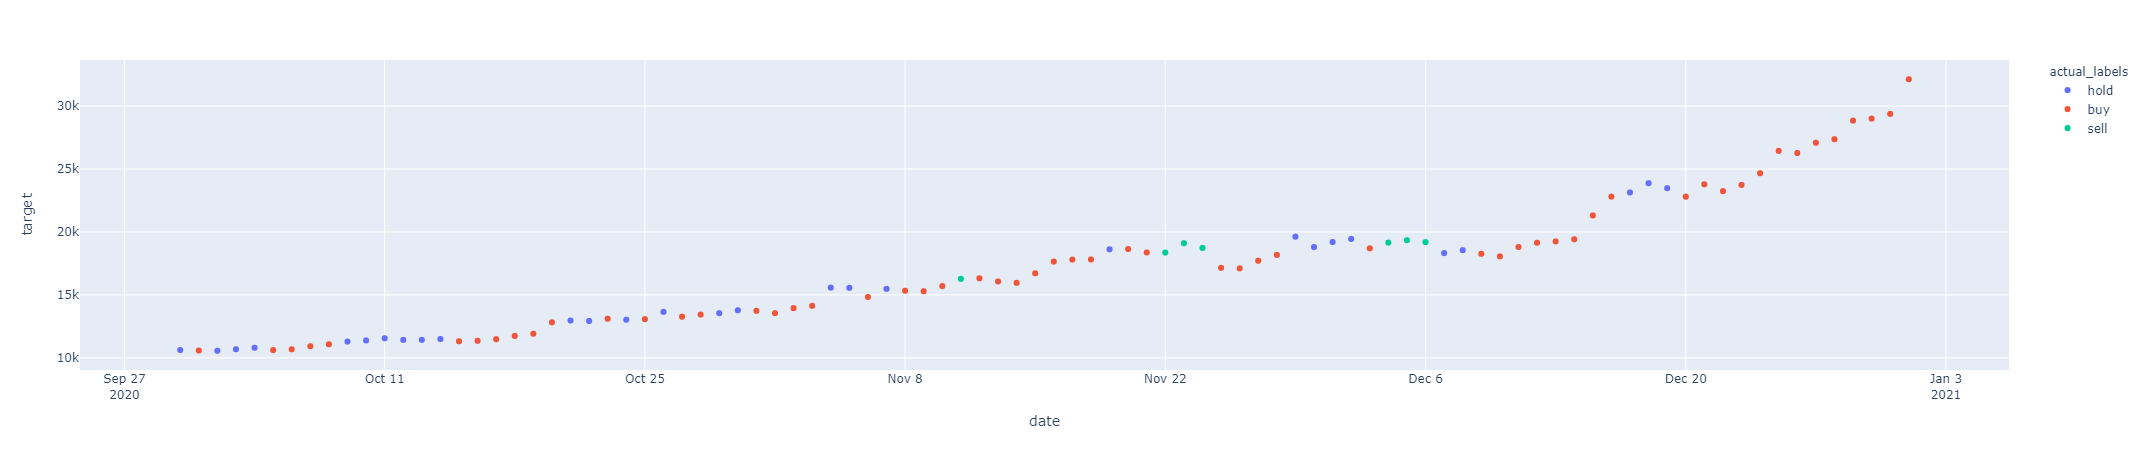

In [222]:
px.scatter(simulation_df, x=simulation_df.index, y='target', color='actual_labels')

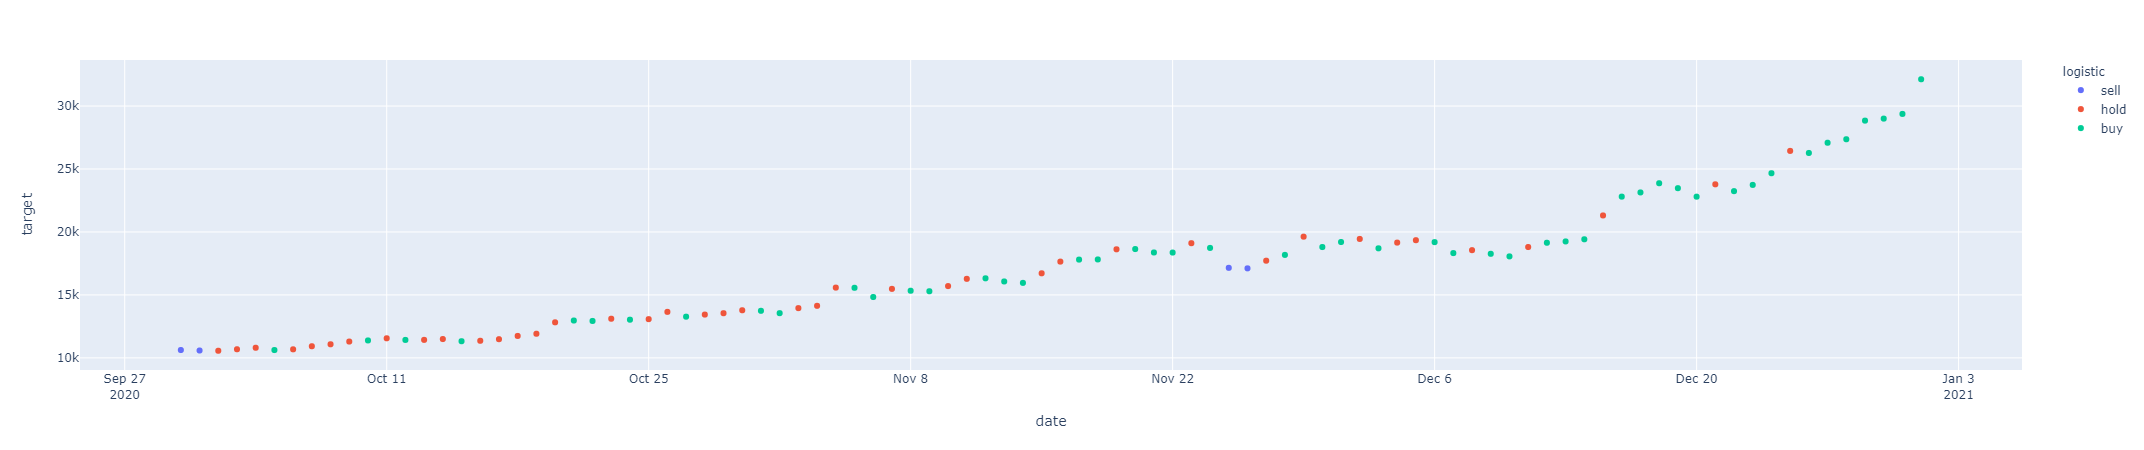

In [223]:
px.scatter(simulation_df, x=simulation_df.index, y='target', color='logistic')

In [131]:
cap_pred, log = Simulation(15000).play_simulation(simulation_df, 'logistic')
cap_random, log = Simulation(15000).play_simulation(simulation_df, 'random_labels')
best_cap, log = Simulation(15000).play_simulation(simulation_df, 'actual_labels')

cap_pred, cap_random, best_cap

(12715.999999999989, 33763.000000000015, 177983.50000000003)

In [106]:
best_cap, log = Simulation(15000).play_simulation(sim_df, 'actual_labels')
log

,type,price,vol,cap,cur_vol
0,buy,10585.2,1,4414.8,1
1,sell,16276.3,1,20691.1,0
2,buy,16317.8,1,4373.3,1
3,sell,18364.1,1,22737.4,0
4,buy,17150.6,1,5586.8,1
5,sell,19154.2,1,24741.0,0
6,buy,18265.0,1,6476.0,1
7,sell,39371.0,1,45847.0,0
8,buy,35566.7,1,10280.3,1
9,sell,37316.4,1,47596.7,0
